In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import math

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from sklearn.metrics import roc_auc_score, average_precision_score
# Path for dataset downloads
DATASET_PATH = "../data"

# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn.models.autoencoder import InnerProductDecoder
from torch_geometric.nn import GCNConv
from torch_geometric import seed_everything

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# graphviz
try: 
    import pygraphviz
except ModuleNotFoundError:
  !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
  !sudo pip install pygraphviz
from IPython.display import Image


cpu


In [33]:
seed_everything(42)

## MUTAG Dataset: Custom Graph Autoencoder
> Graph Autoencoder

> molecule dataset with bond types as edge attributes (one-hot-encoded)

> Encode and reconstruct adjacency matrix and edge attributes

In [34]:
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")

In [35]:
elements = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
bonds = ['arom', 'sngl', 'dbl', 'trpl']

In [36]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))

Data object: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Length: 188


In [37]:
data = tu_dataset[3]

In [38]:
input_data = data

In [39]:
input_data

Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])

In [40]:
input_data.edge_attr

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1.,

In [41]:
def createGraphvizEdgeAttributes(edge_attributes, edge_index):
  edge_attrs_graphviz = {}
  num_edges = edge_index[0].size()[0] - 1
  for idx, edge_attr in enumerate(edge_attributes):
    if idx <= num_edges:
      # Get start node of edge
      start = edge_index[0][idx].item()

      # Get end node of edge
      end = edge_index[1][idx].item()

      # Convert one-hot label
      label = bonds[edge_attr.argmax()]

      # Add label to list
      edge_attrs_graphviz[(start,end)] = {"label": label}
      #print(edge_attrs_graphviz)
  return edge_attrs_graphviz


In [42]:
# Create graphviz edge labels with bond types
edge_attrs_graphviz = createGraphvizEdgeAttributes(input_data.edge_attr, input_data.edge_index)

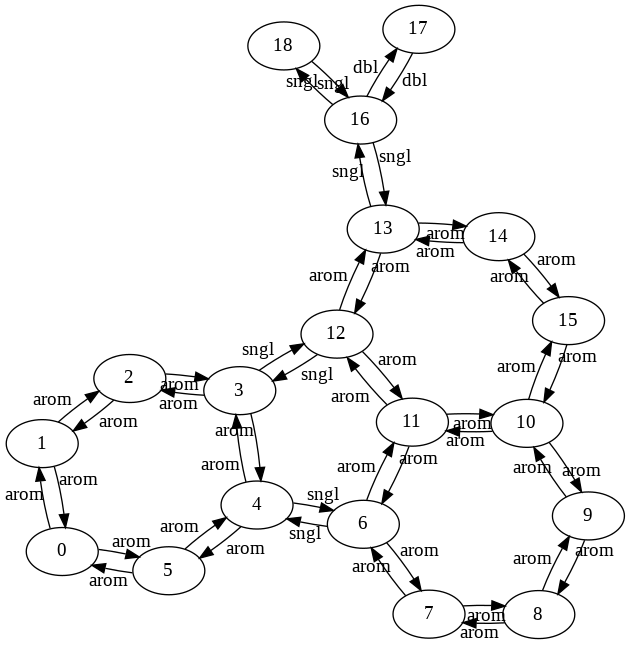

In [43]:
g = torch_geometric.utils.to_networkx(input_data, node_attrs=None, edge_attrs=None, to_undirected=False, remove_self_loops=False)
nx.set_edge_attributes(g, edge_attrs_graphviz)
A = nx.nx_agraph.to_agraph(g)
A.layout(prog='neato')
A.draw("graph.png")
Image('graph.png')

## Define Encoder

In [44]:
# Encode Adjacency Matrix and Edge Attributes
# Inputs:  Node features, Edges, Edge Attributes
# Output Adjacency: (num_nodes, num_enc_nodes)
# Output Edge Features: (num_edges, num_enc_nodes)
class AdjEdgeAttributesEncoder(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_attributes, num_enc_nodes):
      super(AdjEdgeAttributesEncoder, self).__init__()

      hidden_size = 6 * (num_enc_nodes)

      # Node features graph convolutional layer
      self.conv_node_features1 = GCNConv(num_node_features, hidden_size)
      self.conv_node_features2 = GCNConv(hidden_size, hidden_size)
      self.conv_node_features3 = GCNConv(hidden_size, hidden_size)

      # Linear layers for edge attributés
      self.linear_edge_attributes = nn.Linear(num_edge_attributes, hidden_size)
      self.linear_edge_attributes2 = nn.Linear(hidden_size, hidden_size)

      # Output layer 
      self.output = nn.Linear(hidden_size, num_enc_nodes)

    # Forward pass with inputs:
    # node_features_input: (num_nodes, num_node_features)
    # edges_input: (2, num_edges)
    # edge_features_input: (num_edges, num_edge_features)
    def forward(self, node_features_input, edges_input, edge_features_input):

        # Node features convolutions
        conv_node_features1 = self.conv_node_features1(node_features_input, edges_input).relu()
        conv_node_features2 = self.conv_node_features2(conv_node_features1, edges_input).relu()
        conv_node_features3 = self.conv_node_features3(conv_node_features2, edges_input).relu()

        # Linear layers for edge attributes
        linear_edge_attributes = self.linear_edge_attributes(edge_features_input).relu()
        linear_edge_attributes2 = self.linear_edge_attributes2(linear_edge_attributes).relu()

        # Concatenate node features and edge attributes layers
        # Dimensions: ((num_nodes+num_edges), num_enc_nodes)
        concat = torch.cat([conv_node_features3, linear_edge_attributes2]).relu()

        return self.output(concat)

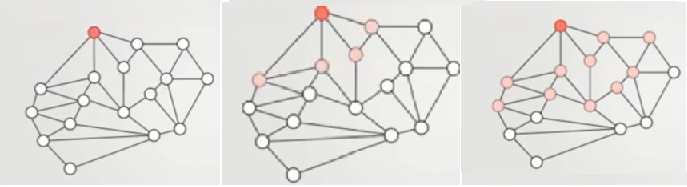

**Messaging Passing**
* Idee: jede Layer eines Graph-Netzwerkes erzeugt neues Embedding der Node Features zusammen mit den Features der Nachbarn (durch Kanten verbundene Nodes). Direkte Nachbarn = 1 Hop, Nachbarn d. Nachbarn = 2-Hops
* einfachste Form: Durschnitt aller Node Embeddings der Nachbarn: Summe der Node Embeddings/Anzahl der Nachbarn wird zu originalen Node Features hinzuaddiert
* damit werden mit jedem Durchlauf die Features von einem 'Hop' weiter entfernten Nachbarn mit hinzugenommen und können die Gewichtungen der Node beeinflussen.




## Define Decoder

In [45]:
## Edge attributes decoder
# softmax output with ReLU layer
# Input:  num_encoding_nodes x num_edges (encoded edge attributes)
# Output: num_edges x num_edge_features (prob. one-hot encoded edge features)
class SoftmaxDecoder(torch.nn.Module):
    def __init__(self, num_enc_nodes, num_edge_features):
      super(SoftmaxDecoder, self).__init__()
      self.linear = nn.Linear(num_enc_nodes, num_edge_features)

    def forward(self, z):
      x = self.linear(z).relu()
      softmax = nn.Softmax(dim=1)
      return softmax(x)


In [46]:
class AdjEdgeAttributesDecoder(torch.nn.Module):
    def __init__(self, num_enc_nodes, num_edge_features):
      super(AdjEdgeAttributesDecoder, self).__init__()
      self.AdjDecoder = InnerProductDecoder()
      self.EdgeAttrDecoder = SoftmaxDecoder(num_enc_nodes, num_edge_features)

    def forward(self, z_adj, edge_index, z_edge_attr):
        AdjDecoder.forward(self, z_adj, edge_index)
        EdgeAttrDecoder.forward(z_edge_attr)

## Define Custom Autoencoder
> encode and decode edges and edge attributes 

In [47]:
EPS = 1e-15
MAX_LOGSTD = 10
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)

In [48]:
class CustomGAE(torch.nn.Module):

    def __init__(self,num_node_features, num_edge_attributes, num_enc_nodes):
        super().__init__()
        self.encoder = AdjEdgeAttributesEncoder(num_node_features, num_edge_attributes, num_enc_nodes)
        self.decoder = AdjEdgeAttributesDecoder(num_enc_nodes, num_edge_attributes)

    # Runs the encoder and computes latent variables.
    # Splits z into
    # z_adj: (num_nodes x num_encoding_nodes)
    # z_edge_attrs: (num_edges x num_encoding_nodes)
    def encode(self, node_features_input, input_edges, input_edge_attrs):

        num_nodes = node_features_input.size()[0]
        num_edges = input_edge_attrs.size()[0]

        z = self.encoder(node_features_input, input_edges, input_edge_attrs)
        z_adj = z[:num_nodes]
        z_edge_attrs = z[-num_edges:]
        return (z_adj, z_edge_attrs)

    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    # Calculate reconstruction loss for edge attributes using Cross-Entropy Loss
    def recon_loss_edge_attrs(self, z, true_edge_attrs):
      #print(f"Z edge attributes size: {z.size()}")
      predicted = self.decoder.EdgeAttrDecoder(z)
      cross_entropy_loss = nn.CrossEntropyLoss()
      loss = cross_entropy_loss(predicted, true_edge_attrs)
      return loss

    # Calculate reconstruction loss for adjacency matrix
    def recon_loss_adj(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder.AdjDecoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder.AdjDecoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()
        return pos_loss + neg_loss

    # Reconstruction loss of adjacency matrix and edge attributes
    def recon_loss(self, z_adj, true_edges, z_edge_attrs, true_edge_attrs):
      loss_adj = self.recon_loss_adj(z_adj, true_edges)
      print(f"loss adjacency: {loss_adj}")
      loss_edge_attr = self.recon_loss_edge_attrs(z_edge_attrs, true_edge_attrs)
      print(f"loss edge attributes: {loss_edge_attr}")
      print(f"combined loss: {loss_edge_attr + loss_adj}\n")
      return  loss_adj + loss_edge_attr 
    
    def train_model(self, node_features_input, true_edges, input_edge_attrs, true_edge_attrs, optimizer):
      # Set model in training mode
      self.train()
      # Set gradients to zero for each batch
      optimizer.zero_grad()
      # Separate combined latent output into z_adj and z_edge_attrs
      z_adj, z_edge_attrs = model.encode(node_features_input, input_edges, input_edge_attrs)
      # Combined loss for adjacency matrix and edge attributes
      loss = self.recon_loss(z_adj, true_edges, z_edge_attrs, true_edge_attrs)
      # Compute gradients
      loss.backward()
      # Adjust weights
      optimizer.step()
      return float(loss)

# **Pytorch Autograd demo**

In [49]:
a = torch.linspace(0., 100., steps=6, requires_grad=True)
print(a)
b = 2 * a
c = b + 1
out = c.sum()
print(out.grad_fn)
print(out.grad_fn.next_functions)
print(out.grad_fn.next_functions[0][0].next_functions)
out.backward()
print(a.grad)

tensor([  0.,  20.,  40.,  60.,  80., 100.], requires_grad=True)
((<AddBackward0 object at 0x7fa649a9e450>, 0),)
((<MulBackward0 object at 0x7fa649a94090>, 0), (None, 0))
tensor([2., 2., 2., 2., 2., 2.])


##Create and train model

In [50]:
# parameters
num_enc_nodes = 2
num_node_features = input_data.num_features
num_edge_attributes = input_data.num_edge_features
epochs = 500

# model
model = CustomGAE(num_node_features, num_edge_attributes, num_enc_nodes)

# Input data
input_node_features = input_data.x
input_edges = input_data.edge_index
input_edge_attrs = input_data.edge_attr


print(f"Shape Node Features: {input_node_features.size()}")
print(f"Shape Edges: {input_edges.size()}")
print(f"Shape Edge Attributes: {input_edge_attrs.size()}")

# initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Shape Node Features: torch.Size([19, 7])
Shape Edges: torch.Size([2, 44])
Shape Edge Attributes: torch.Size([44, 4])


In [51]:
for param in model.decoder.parameters():
  print(param)

Parameter containing:
tensor([[-0.4822,  0.1318],
        [ 0.2924, -0.1461],
        [-0.0592,  0.3183],
        [-0.1188, -0.5938]], requires_grad=True)
Parameter containing:
tensor([ 0.5658, -0.3559, -0.0777,  0.0667], requires_grad=True)


In [52]:
for epoch in range(1, epochs + 1):
      loss = model.train_model(input_node_features, input_edges, input_edge_attrs, input_edge_attrs, optimizer)

loss adjacency: 1.3878188133239746
loss edge attributes: 1.2927355766296387
combined loss: 2.6805543899536133

loss adjacency: 1.3878343105316162
loss edge attributes: 1.292129635810852
combined loss: 2.679964065551758

loss adjacency: 1.3877885341644287
loss edge attributes: 1.2915219068527222
combined loss: 2.6793103218078613

loss adjacency: 1.3877593278884888
loss edge attributes: 1.2909126281738281
combined loss: 2.6786718368530273

loss adjacency: 1.3877434730529785
loss edge attributes: 1.2903014421463013
combined loss: 2.6780447959899902

loss adjacency: 1.3877458572387695
loss edge attributes: 1.2896883487701416
combined loss: 2.677434206008911

loss adjacency: 1.387768030166626
loss edge attributes: 1.2890727519989014
combined loss: 2.6768407821655273

loss adjacency: 1.3877159357070923
loss edge attributes: 1.2884544134140015
combined loss: 2.6761703491210938

loss adjacency: 1.3877487182617188
loss edge attributes: 1.2878260612487793
combined loss: 2.675574779510498

loss a

In [53]:
z_adj, z_edge_attrs = model.encode(input_node_features, input_edges, input_edge_attrs)

## Decode latent representation

In [54]:
# Decode latent representation
# Predicts edges likelihood for given edge index list
# Reconstruct all positive edges
predicted_pos_edges = model.decoder.AdjDecoder(z_adj, input_edges, sigmoid=True)
predicted_pos_edges

tensor([0.6472, 0.6451, 0.6472, 0.6435, 0.6435, 0.6460, 0.6460, 0.6820, 0.5056,
        0.6820, 0.6766, 0.7158, 0.6451, 0.6766, 0.7158, 0.6707, 0.6815, 0.6707,
        0.6364, 0.6364, 0.6406, 0.6406, 0.6776, 0.6776, 0.6832, 0.6153, 0.6815,
        0.6832, 0.5056, 0.5056, 0.5056, 0.4916, 0.4916, 0.6419, 0.9732, 0.6419,
        0.4553, 0.6153, 0.4553, 0.9732, 0.9939, 0.9939, 0.9939, 0.9939],
       grad_fn=<SigmoidBackward0>)

In [55]:
# Convert to binary values [True,False]
predicted_pos_edges = np.where(predicted_pos_edges > 0.5, True, False)
predicted_pos_edges

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True])

In [56]:
print(f"{predicted_pos_edges.shape}")
print(f"{input_edges.shape}")

(44,)
torch.Size([2, 44])


## Create edge indices from predictions

In [57]:
# Select all start nodes where predicted_pos_edges = True
pred_from = np.array(input_data.edge_index[0][predicted_pos_edges])
# Select all end nodes where predicted_pos_edges = True
pred_to = np.array(input_data.edge_index[1][predicted_pos_edges])

# Create new edge index for predicted graph
predicted_pos_edge_index = np.array([pred_from, pred_to])
print(predicted_pos_edge_index.shape)

# Set new predictes edge index in graph
predicted_graph = input_data.clone()
predicted_graph.edge_index =  torch.from_numpy(predicted_pos_edge_index)


(2, 40)


## Decode edge attributes

In [58]:
# Decode latent representation of edge attributes
# Predicts likelihood for one hot encoded edge features
predicted_edge_attributes = model.decoder.EdgeAttrDecoder(z_edge_attrs)

# Get index of maximum softmax value for each edge
max_indices = torch.argmax(predicted_edge_attributes, dim=1, keepdim=True)

# Create new tensor. Copy shape from predicted_edge_attributes
one_hot_pred_edge_attributes = torch.FloatTensor(predicted_edge_attributes.shape)
# Set all values to zero
one_hot_pred_edge_attributes.zero_()

# Scatter value 1 at indices indicated in max_indices
one_hot_pred_edge_attributes.scatter_(1, max_indices, 1)
one_hot_pred_edge_attributes

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1.,

## Decoded graph

In [59]:
# Create graphviz edge labels
edge_attrs_graphviz_predicted = createGraphvizEdgeAttributes(one_hot_pred_edge_attributes, predicted_graph.edge_index)
# Set edge labels
predicted_graph.edge_attr = edge_attrs_graphviz_predicted

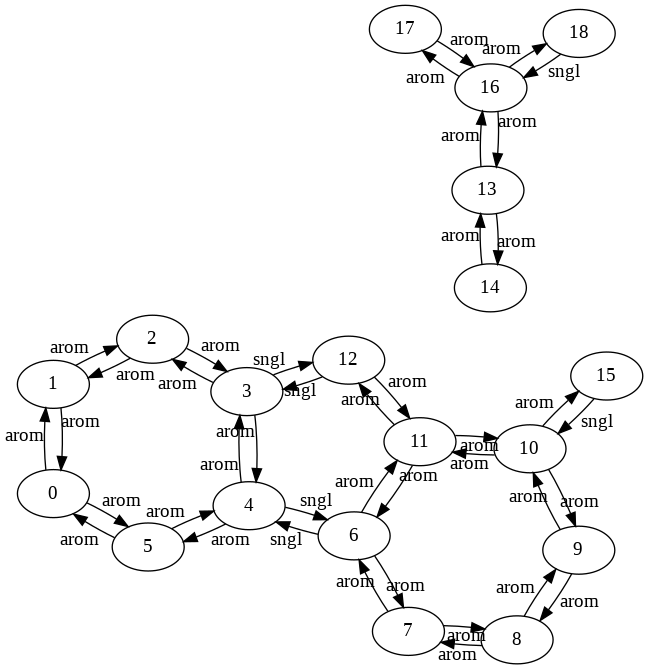

In [60]:
g = torch_geometric.utils.to_networkx(predicted_graph, node_attrs=None, edge_attrs=None, to_undirected=False, remove_self_loops=False)
nx.set_edge_attributes(g, predicted_graph.edge_attr)
A = nx.nx_agraph.to_agraph(g)
A.layout(prog='neato')
A.draw("graph.png")
Image('graph.png')

## Original graph

In [61]:
# Create graphviz edge labels
edge_attrs_graphviz = createGraphvizEdgeAttributes(input_data.edge_attr, input_data.edge_index)

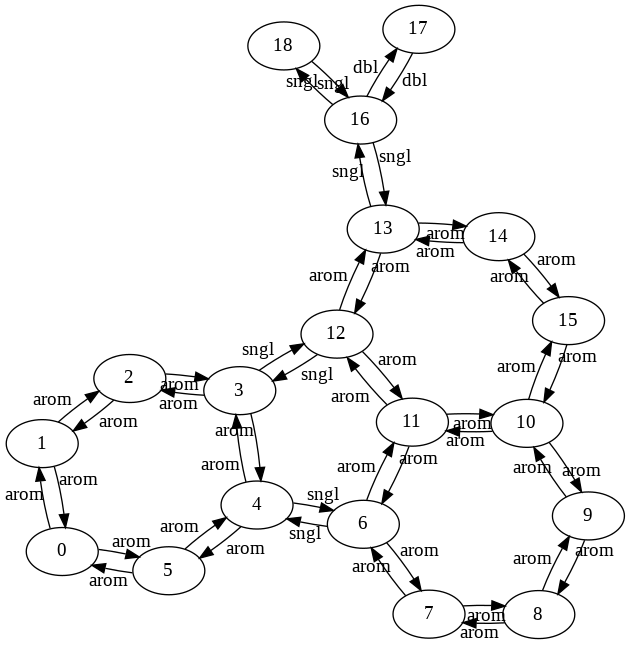

In [62]:
g = torch_geometric.utils.to_networkx(input_data, node_attrs=None, edge_attrs=None, to_undirected=False, remove_self_loops=False)
nx.set_edge_attributes(g, edge_attrs_graphviz)
A = nx.nx_agraph.to_agraph(g)
#print(A.to_string())
A.layout(prog='neato')
A.draw("graph.png")
Image('graph.png')